In [0]:
#imports 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import  GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = '1q8cR7hj3xuZaVdKJUD2LOE-r5VI6YBk8'
downloaded = drive.CreateFile({'id':file_id})
#print('Downloaded content"{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('YelpDataset.zip')

In [4]:
ls

adc.json  sample_data/  YelpDataset.zip


In [5]:
%%time
import zipfile
with zipfile.ZipFile("YelpDataset.zip","r") as zip_ref:
  print('extracting zip file')
  zip_ref.extractall("targetdir")

extracting zip file
CPU times: user 4.35 s, sys: 735 ms, total: 5.08 s
Wall time: 5.18 s


In [6]:
ls


adc.json  sample_data/  targetdir/  YelpDataset.zip


In [7]:
cd targetdir/

/content/targetdir


In [8]:
ls

__MACOSX/  YelpDataset/


In [9]:
cd YelpDataset/

/content/targetdir/YelpDataset


In [10]:
ls

business.json  checkin.json  tip.json  user.json  user_reviews.json


In [11]:
!pip install surprise


     |████████████████████████████████| 6.5MB 4.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678274 sha256=a3705d36b091df416ebcd38456dbc12646793be3b8f9fb513885422daf784f25
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [12]:
!pip install wordcloud

In [13]:
# Basic imports
%%time
import pandas as pd
import os, sys
import time
import gc
import numpy as np
from math import sqrt
import string
import warnings
import itertools
import datetime
warnings.filterwarnings('ignore')

#imports for visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import plot, iplot, init_notebook_mode
import networkx as nx
from wordcloud import WordCloud

# importing libraries for NLP
import nltk
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob, Word
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter

#importing libraries for modelling
import sklearn.metrics as metrics
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine

#importing libraries for recommendations
from surprise import SVD, SVDpp, Dataset, accuracy, Reader, BaselineOnly, KNNBaseline
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
#import evaluate
#from surprise import evaluate, print_perf
#importing pickle library
import pickle


CPU times: user 965 ms, sys: 272 ms, total: 1.24 s
Wall time: 2.23 s


In [14]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
 

True

In [0]:
#reading data from all json files 
user_ds=pd.read_json('user.json')
business_ds=pd.read_json('business.json')
checkin_ds=pd.read_json('checkin.json')
tip_ds=pd.read_json('tip.json')
review_ds=pd.read_json('user_reviews.json')

# **1. SENTIMENT ANALYSIS AND PREDICTION USING NAIVE BIAS ALGORITHM**

The idea is to create a **baseline model** where we just pick the review text and remove the punctuations only and try to predict the rating on the review by using Naive Bias Algorithm. We then do all the text-preprocessing which involves removal of stopwords, applying lemmatization and bagOfWords technique to the reviews and then try to predict the rating again. The aim is to compare and analyse whether doing all the text preprocessing has an impact on the prediction or not. If so, how significant is the imapct on the reveiws. This is being evaluated by looking at the **confusion matrix** and **classification report consisting of precision, recall and f1-score**

**1.1 TEXT ANALYSIS OF REVIEW TEXT**


In [16]:
# Word count in the review text
review_ds['word_count'] = review_ds['text'].apply(lambda x: len(str(x).split(" ")))
review_ds[['text','word_count']].head()


,text,word_count
0,Total bill for this horrible service? Over $8G...,39
1,I *adore* Travis at the Hard Rock's new Kelly ...,288
2,I have to say that this office really has it t...,113
3,Went in for a lunch. Steak sandwich was delici...,65
4,Today was my second out of three sessions I ha...,673


In [17]:
# Character count in the review text
review_ds['char_count'] = review_ds['text'].str.len() ## this also includes spaces
review_ds[['text','char_count']].head()

,text,char_count
0,Total bill for this horrible service? Over $8G...,204
1,I *adore* Travis at the Hard Rock's new Kelly ...,1561
2,I have to say that this office really has it t...,615
3,Went in for a lunch. Steak sandwich was delici...,407
4,Today was my second out of three sessions I ha...,3509


In [18]:
# Average word length in the review text sentence
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

review_ds['avg_word'] = review_ds['text'].apply(lambda x: avg_word(x))
review_ds[['text','avg_word']].head()
review_ds['text'][1]

"I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon!  I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level!  \n\nTravis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit.  Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room.  Travis has freakishly strong fingers (in a good way) and use the perfect amount of pressure.  That was superb!  Then starts the glorious blowout... where not one, not two, but THREE people were involved in doing the best round-brush action my hair has ever seen.  The team of stylists clearly gets along extremely well, as it's evident from the way they talk to and help one another that it's really genuine and not some corporate requirement.  It was so mu

In [19]:
# Checking texts that starts with hashtags
review_ds['hashtags'] = review_ds['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
review_ds[['text','hashtags']].head()

,text,hashtags
0,Total bill for this horrible service? Over $8G...,0
1,I *adore* Travis at the Hard Rock's new Kelly ...,0
2,I have to say that this office really has it t...,0
3,Went in for a lunch. Steak sandwich was delici...,0
4,Today was my second out of three sessions I ha...,0


In [20]:
# Count of stopwords present in the review text
stop = stopwords.words('english')

review_ds['stopwords'] = review_ds['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
review_ds[['text','stopwords']].head()

,text,stopwords
0,Total bill for this horrible service? Over $8G...,13
1,I *adore* Travis at the Hard Rock's new Kelly ...,101
2,I have to say that this office really has it t...,52
3,Went in for a lunch. Steak sandwich was delici...,23
4,Today was my second out of three sessions I ha...,308


In [21]:
# Count of numerics present in the review text
review_ds['numerics'] = review_ds['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
review_ds[['text','numerics']].head()

,text,numerics
0,Total bill for this horrible service? Over $8G...,2
1,I *adore* Travis at the Hard Rock's new Kelly ...,0
2,I have to say that this office really has it t...,0
3,Went in for a lunch. Steak sandwich was delici...,0
4,Today was my second out of three sessions I ha...,6


In [22]:
# Top 10 frequent words
freq_top = pd.Series(' '.join(review_ds['text']).split()).value_counts()[:10]
freq_top


the    438333
and    367823
I      277006
a      265334
to     258979
was    188121
of     152624
is     127496
for    122749
in     111121
dtype: int64

In [23]:
# Least 10 frequent words
freq_least = pd.Series(' '.join(review_ds['text']).split()).value_counts()[-10:]
freq_least

calimari...      1
"ouch"           1
"all-dressed"    1
Foresthill       1
matiinee,        1
lactose-free     1
convenable       1
tursday          1
dissappoints.    1
JPL              1
dtype: int64

In [24]:
# Includig the text length column in review dataset
review_ds['text length'] = review_ds['text'].apply(len)
review_ds.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA,39,204,4.256410,0,13,2,204
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg,288,1561,4.627737,0,101,0,1561
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw,113,615,4.614679,0,52,0,615
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg,65,407,4.955882,0,23,0,407
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ,673,3509,4.215453,0,308,6,3509


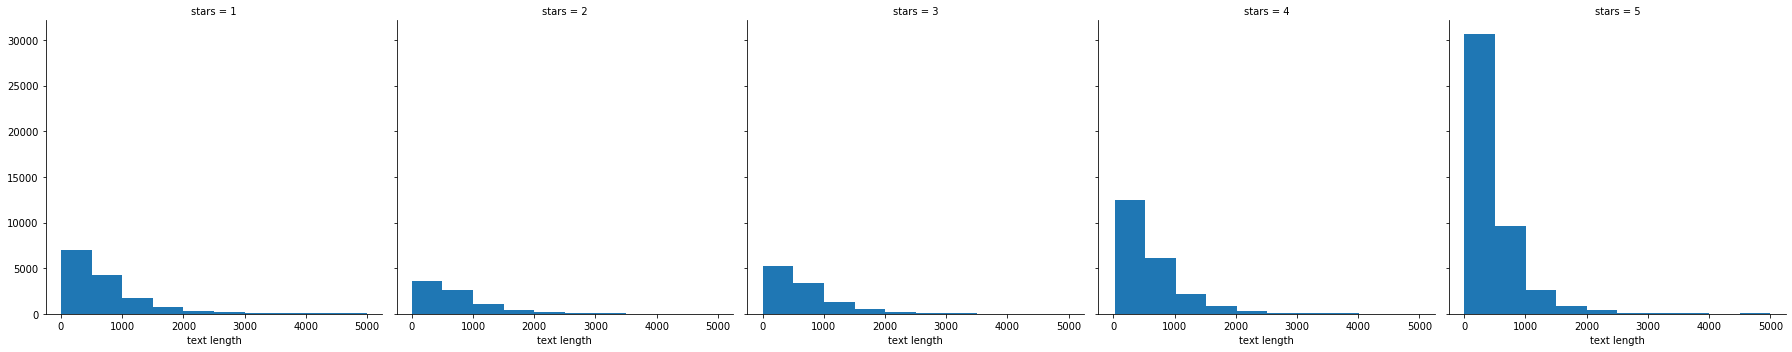

In [25]:
# Visualising the review text and stars for a business

graph = sns.FacetGrid(data=review_ds, col='stars',height=5)

graph.map(plt.hist, 'text length', bins=10)


### **1.2 BASELINE MODEL AND PREDICTION USING NAIVE BIAS ALGORITHM**

In this model, we take into consideration the review text where we only remove the punctuations in the text and perform text analysis to predict the user ratings on the basis of review text using Naive Bias algorithm. The result is evaluated by the confusion matrix and classification report consisting of recall, precision and f1-score


In [0]:
# separating our features and target
X = review_ds['text']
y = review_ds['stars']


In [0]:
# function to remove only punctuations from the review text
def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Removes all punctuation
    2. Return the text as a list of words
    '''

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split()]

In [28]:
# Let us test if the above function worked correctly!
sample_text = "Hey there! This is a sample review, which happens to contain punctuations."

print(text_process(sample_text))

['Hey', 'there', 'This', 'is', 'a', 'sample', 'review', 'which', 'happens', 'to', 'contain', 'punctuations']


In [0]:
# creating a bag of words which consist of entire text without punctuations and fiting it
bow_transformer = CountVectorizer().fit(X)

In [30]:
# Looking for the count of features
len(bow_transformer.vocabulary_)

77548

In [0]:
# Let us now transform our review text
#%%time
X = bow_transformer.transform(X)

In [32]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (100000, 77548)
Amount of Non-Zero occurrences:  6979135
Density: 0.08999761438077061


In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (70000, 77548)
Number transactions y_train dataset:  (70000,)
Number transactions X_test dataset:  (30000, 77548)
Number transactions y_test dataset:  (30000,)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [34]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_train==2)))
print("Before OverSampling, counts of label '3': {}".format(sum(y_train==3)))
print("Before OverSampling, counts of label '4': {}".format(sum(y_train==4)))
print("Before OverSampling, counts of label '5': {} \n".format(sum(y_train==5)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res==4)))
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res==5)))

Before OverSampling, counts of label '1': 10162
Before OverSampling, counts of label '2': 5593
Before OverSampling, counts of label '3': 7762
Before OverSampling, counts of label '4': 15361
Before OverSampling, counts of label '5': 31122 

After OverSampling, the shape of train_X: (155610, 77548)
After OverSampling, the shape of train_y: (155610,) 

After OverSampling, counts of label '1': 31122
After OverSampling, counts of label '2': 31122
After OverSampling, counts of label '3': 31122
After OverSampling, counts of label '4': 31122
After OverSampling, counts of label '5': 31122


In [35]:
# Let us now train the model using Multinomial Naive Bais Algorithm
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
finalized_model = open("Naive_Bais_Model.pkl", "wb")
pickle.dump(nb, finalized_model)

In [0]:
# Let us now predict on the test set
nb_preds = nb.predict(X_test)
nb_prob = nb.predict_proba(X_test)

Confusion Matrix of the Naive Bayes 

 [[9392 3063   88   43  659]
 [1827 4243  376   73  223]
 [ 279 1430  963  194  342]
 [ 110  377  726  472  697]
 [ 103  177  349  574 3220]] 



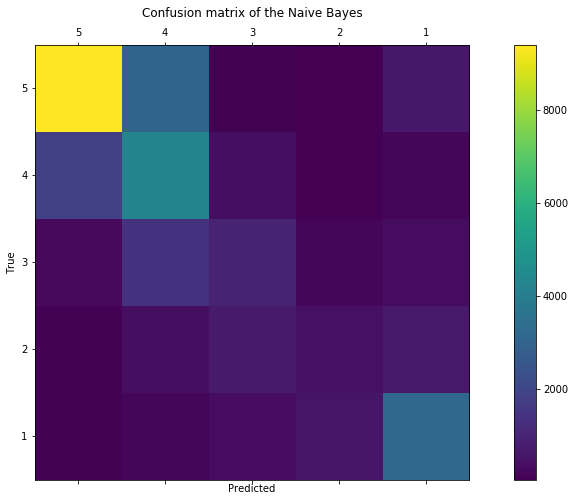

In [130]:
# Let us now evaluate and plot Confusion Matrix 

labels = [5,4,3,2,1]
nb_cm = confusion_matrix(y_test, nb_preds, labels)
print('Confusion Matrix of the Naive Bayes \n\n',nb_cm,'\n')
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
cax = ax.matshow(nb_cm)
plt.title('Confusion matrix of the Naive Bayes')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
# Let us now evaluate our model using classification report
nb_cr = classification_report(y_test, nb_preds)
print('               Classification Report for Naive Bayes\n')
print(nb_cr)


               Classification Report for Naive Bayes

              precision    recall  f1-score   support

           1       0.63      0.73      0.67      4423
           2       0.35      0.20      0.25      2382
           3       0.38      0.30      0.34      3208
           4       0.46      0.63      0.53      6742
           5       0.80      0.71      0.75     13245

    accuracy                           0.61     30000
   macro avg       0.52      0.51      0.51     30000
weighted avg       0.62      0.61      0.61     30000



In [131]:
# Let us now calculate accuracy score
nb_acc = metrics.accuracy_score(y_test, nb_preds)
print("Accuracy Score of Naive Bayes Model\n")
print(nb_acc)

Accuracy Score of Naive Bayes Model

0.6096666666666667


**Observation** :

1) From above, we observe that the misclassification rate is quite high for each of the ratings. It is still better for 1 star and 5 star ratings.

2) 2 star rating has a higher misclassified rating as compared to its true positives where it wrongly predicts it as a 1 star rating majority of the times.

3) 3 star rating also has high misclassification rate where there is almost equal number of chances that it wrongly predicts the rating as a 2 star rating.

4) Looking at the precision and recall for each of the ratings, we see that it is least for 2 star rating. The values for 3 star and 4 star ratings are also not very good which signifies that the model is not good and there is a higher probablity that it will wrongly predict the ratings.

Some of the examples are shown below -

## **Predicting positive reviews :**


In [41]:
review_ds.tail()


,business_id,cool,date,funny,review_id,stars,text,useful,user_id,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length
99995,PeU2rTATIarPVjOyzvY-Fg,2,2015-11-08 03:38:13,3,R3OQnzCBPtD6e3XJbm7vaw,3,I love the clothes in Aritzia. The service I c...,3,kZA-neTnGq6gzLt7k70kEQ,147,753,4.020134,0,66,0,753
99996,YRyYbOSwvHkZsZOLv98oQg,1,2012-03-05 22:16:28,11,C0M_WaqYfHZTuE4Y6t-imA,1,We went here to have a small dinner with famil...,9,7D4A_euL-c2-X9d51TnZtw,288,1375,3.927273,0,122,3,1375
99997,Der6cNgKbShEMR2jry1Tmg,0,2018-08-06 02:18:48,0,AYSWzH_46u-ZosyA-_z24A,5,Amazing!!! Our 2 boys never had this much fun ...,0,Mfn6rBrTZg1ysBoknKt1TQ,45,258,4.755556,0,12,1,258
99998,LVG3B79xZfjLcjfJUQId0A,0,2017-06-18 19:50:46,0,zn9SwnAilArrWHKZ8141Tg,5,Wanted a short hair cut but didn't have a regu...,2,_D9uaoR1I9o2aIEODh4r9A,114,613,4.385965,0,48,0,613
99999,e4h-sBBD70pn1RuAv_Q61w,4,2015-09-26 02:53:39,1,mOMTlXyIUF6v8n9yUgZDgA,5,"This place is rad! Dueling pianos, happy hour ...",2,zemsVfzVyyJDPRg6742H4Q,90,491,4.466667,0,29,0,491


In [0]:
from random import randint
def predict_review_ds(n,bow_transformer,nb,review_ds):
    value = randint(0,n)
    print('The row that has been selected is', value)
    review_verdict = review_ds['text'][value]
    review_verdict_transformed = bow_transformer.transform([review_verdict])
    predicted_rating = nb.predict(review_verdict_transformed)[0]
    check_df = pd.DataFrame(columns=review_ds.columns)
    check_df.loc[0] = review_ds.iloc[value]
    check_df['Predicted'] = predicted_rating
    return check_df

In [43]:
predict_review_ds(55,bow_transformer,nb,review_ds)


The row that has been selected is 47


,business_id,cool,date,funny,review_id,stars,text,useful,user_id,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length,Predicted
0,jzveTy7ogH7cg9axZ78ENg,0,2015-04-01 13:31:35,0,0NRNA8qIq9nKw5FcwyOxcQ,4,Very nice eating environment and the food are ...,0,54kpqrxF9DEPpwa51hO_Bw,14,85,5.142857,0,3,0,85,4


Thus, we see that the actual rating was 4 for the reveiw and our model very well predicted that rating.We shall test for another positive reveiw.


Now, let us try to create another model where we remove all the stopwords and perform lemmatisation and other text processing. We will then try to predict the ratings using Naive Baised Model and test for our predictions.

## **1.3 ADVANCE MODEL AFTER REMOVAL OF STOPWORDS AND OTHER PRE-PROCESSING TECHNIQUE TO PREDICT RATINGS USING MULTINOMIAL NAIVE BIAS**



In [0]:
# function to segregate the Part Of Speech in the review text
# n - noun, v - verb, a - adverb, r - adverb
from nltk.corpus import wordnet
from collections import Counter
def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(4)
    return most_common_pos_list[0][0]

In [0]:
# function to perform text preprocessing on the review text
def preprocessing(text):
    
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # lower capitalization
    tokens = [word.lower() for word in tokens]
    
    # remove stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]
    
    # remove punctuations
    tokens = [char for char in tokens if char not in string.punctuation]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(x, get_pos(x)) for x in tokens]
    #tokens = [lmtzr.lemmatize(word, pos='v') for word in tokens]
    preprocessed_text= ' '.join(tokens)

    return preprocessed_text


In [46]:
# sample text to check if the above function worked
sample_text = "Hey there! There are many cats running but I like just I cat!! This is a sample reviews, which happens to contain punctuations."

print(preprocessing(sample_text))

hey many cat run like cat sample review happen contain punctuation


In [0]:
# separating our features and target 
X = review_ds['text']
y = review_ds['stars']

In [0]:
# creating a bag of words which consist of entire preprocessed review text and fiting it
#%%time
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=preprocessing).fit(X)

In [49]:
# Looking at the count of features in the model
len(bow_transformer.vocabulary_)

1229

In [0]:
# Transforming our features in the model
#%%time
X = bow_transformer.transform(X)

In [51]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (100000, 1229)
Amount of Non-Zero occurrences:  2640194
Density: 2.148245728234337


In [52]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (70000, 1229)
Number transactions y_train dataset:  (70000,)
Number transactions X_test dataset:  (30000, 1229)
Number transactions y_test dataset:  (30000,)


In [53]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_train==2)))
print("Before OverSampling, counts of label '3': {}".format(sum(y_train==3)))
print("Before OverSampling, counts of label '4': {}".format(sum(y_train==4)))
print("Before OverSampling, counts of label '5': {} \n".format(sum(y_train==5)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res==4)))
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res==5)))

Before OverSampling, counts of label '1': 10162
Before OverSampling, counts of label '2': 5593
Before OverSampling, counts of label '3': 7762
Before OverSampling, counts of label '4': 15361
Before OverSampling, counts of label '5': 31122 

After OverSampling, the shape of train_X: (155610, 1229)
After OverSampling, the shape of train_y: (155610,) 

After OverSampling, counts of label '1': 31122
After OverSampling, counts of label '2': 31122
After OverSampling, counts of label '3': 31122
After OverSampling, counts of label '4': 31122
After OverSampling, counts of label '5': 31122


In [54]:
# Training our model using Multinomial Naive Bais Algorithm
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
# Predict on the test set
adv_nb_preds = nb.predict(X_test)

Confusion Matrix
 [[11066   553   157   150  1319]
 [ 4829   705   203   149   856]
 [ 1963   342   164   128   611]
 [ 1360   185    91    88   658]
 [ 2193   162    88   132  1848]] 



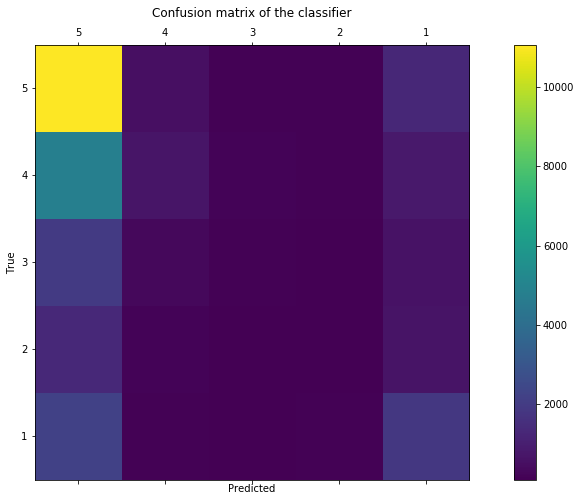

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
# Let us now evaluate and plot Confusion Matrix 

labels = [5,4,3,2,1]
adv_nb_cm = confusion_matrix(y_test, adv_nb_preds, labels)
print('Confusion Matrix\n',adv_nb_cm,'\n')
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
cax = ax.matshow(adv_nb_cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [57]:
# Let us now evaluate our model using classification report
adv_nb_cm = classification_report(y_test, adv_nb_preds)
print(adv_nb_cm)

              precision    recall  f1-score   support

           1       0.35      0.42      0.38      4423
           2       0.14      0.04      0.06      2382
           3       0.23      0.05      0.08      3208
           4       0.36      0.10      0.16      6742
           5       0.52      0.84      0.64     13245

    accuracy                           0.46     30000
   macro avg       0.32      0.29      0.26     30000
weighted avg       0.40      0.46      0.39     30000



In [58]:
# Let us now calculate accuracy score
adv_nb_acc = metrics.accuracy_score(y_test, adv_nb_preds)
print(adv_nb_acc)

0.46236666666666665


Observation :

From above, we observe that the misclassification rate is still high for each of the ratings. 2 star rating is poorly predicted whereas a 5 star rating as much better prediction results compared to other ratings.

2 star rating has a higher misclassified rating as compared to its true positives where it wrongly predicts it as a 5 star rating majority of the times.

3 star rating also has high misclassification rate where there is almost equal number of chances that it wrongly predicts the rating as a 5 star rating.

Looking at the precision, recall and f1-score for each of the ratings, we see that it is least for 3 star rating. The values for 2 star and 4 star ratings are also not very good which signifies that the model is not good and there is a higher probablity that it will wrongly predict the ratings.

Also, in comparison to the baseline model we observe that this model under-performed after performing text preprocessing. The reason behind high misclassification rate while our modelling is due to the biased nature of reveiws and stars given by the users. As we had seen above while performing the exploratory data analysis, majority of the users have given more than 3 star rating to the business which is why our model turned bias towards positive reviews and predicts ratings which is more than 3 for most of the scenarios.

Some of the examples are shown below -

## **Prediction of Positive Reviews**

In [0]:
from random import randint
def predict_review(n,bow_transformer,nb,review):
    value = randint(0,n)
    print('The row that has been selected is', value)
    review_verdict = review_ds['text'][value]
    review_verdict_transformed = bow_transformer.transform([review_verdict])
    predicted_rating = nb.predict(review_verdict_transformed)[0]
    check_df = pd.DataFrame(columns=review.columns)
    check_df.loc[0] = review_ds.iloc[value]
    check_df['Predicted'] = predicted_rating
    return check_df


In [60]:
predict_review(100,bow_transformer,nb,review_ds)


The row that has been selected is 68


,business_id,cool,date,funny,review_id,stars,text,useful,user_id,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length,Predicted
0,CZKkoMlqu0N0zCFK-3T_Fg,0,2013-02-21 21:25:07,0,dcKpWjwqKl0ImVKEru6Q1A,4,Great cocktails and very good food. Overall f...,1,X-5IICsYwqImns4WxHi91Q,11,68,5.8,0,2,0,68,5


From above we see that the actual rating was 4 and our model misclassified it as a 5 star rating for the business


# **2. SENTIMENT ANALYSIS AND PREDICTION USING SVM CLASSIFIER**



In [0]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [62]:
classifier = LinearSVC()
clf = CalibratedClassifierCV(classifier) 

clf.fit(X_train,y_train)


CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv='warn', method='sigmoid')

In [0]:
finalized_model = open("SVM_Classifier.pkl", "wb")
pickle.dump(classifier, finalized_model)

In [0]:
# Let us now predict on the test set
svm_preds = clf.predict(X_test)
svm_prob = clf.predict_proba(X_test)

Confusion matrix of the SVM Classifier 

 [[12907   174     3     0   161]
 [ 6260   318    11     0   153]
 [ 2849   208    15     0   136]
 [ 2052    95     9     0   226]
 [ 3745    99     5     1   573]] 



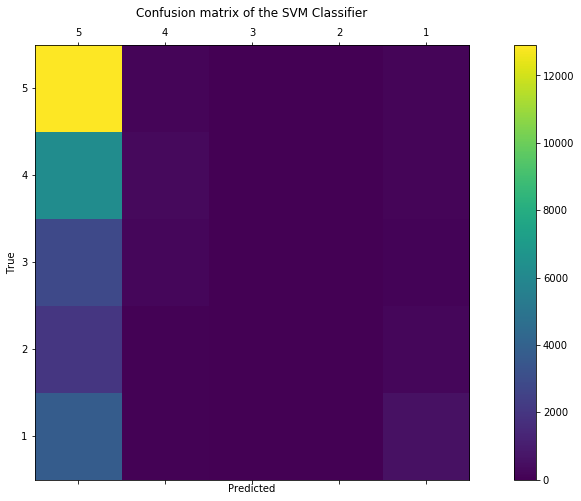

In [132]:
from sklearn.metrics import confusion_matrix, classification_report
# Let us now evaluate and plot Confusion Matrix 

labels = [5,4,3,2,1]
svm_cm = confusion_matrix(y_test, svm_preds, labels)
print('Confusion matrix of the SVM Classifier \n\n',svm_cm,'\n')
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
cax = ax.matshow(svm_cm)
plt.title('Confusion matrix of the SVM Classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [66]:
# Let us now evaluate our model using classification report
svm_cr = classification_report(y_test, svm_preds)
print('               Classification Report for SVM Classifier \n')

print(svm_cr)

               Classification Report for SVM Classifier 

              precision    recall  f1-score   support

           1       0.46      0.13      0.20      4423
           2       0.00      0.00      0.00      2382
           3       0.35      0.00      0.01      3208
           4       0.36      0.05      0.08      6742
           5       0.46      0.97      0.63     13245

    accuracy                           0.46     30000
   macro avg       0.33      0.23      0.18     30000
weighted avg       0.39      0.46      0.33     30000



In [134]:
# Let us now calculate accuracy score
svm_acc = metrics.accuracy_score(y_test, svm_preds)
print("Accuracy Score of SVM Classifier\n")
print(svm_acc)

Accuracy Score of SVM Classifier

0.4604333333333333


## **Prediction of Positive Reviews**


In [0]:
from random import randint
def predict_review_ds(n,bow_transformer,classifier,review_ds):
    value = randint(0,n)
    print('The row that has been selected is', value)
    review_verdict = review_ds['text'][value]
    review_verdict_transformed = bow_transformer.transform([review_verdict])
    predicted_rating = clf.predict(review_verdict_transformed)[0]
    check_df = pd.DataFrame(columns=review_ds.columns)
    check_df.loc[0] = review_ds.iloc[value]
    check_df['Predicted'] = predicted_rating
    return check_df

In [69]:
predict_review(100,bow_transformer,clf,review_ds)


The row that has been selected is 70


,business_id,cool,date,funny,review_id,stars,text,useful,user_id,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length,Predicted
0,KjicU7uxRt2KDEnO5cgxDQ,0,2017-06-27 23:17:40,0,4aX4qoetCm45i4Phut_sww,1,This company tried deliver flowers to our home...,0,gt9w3MAaBemQsUCS_xapMw,300,1515,4.29682,0,128,0,1515,5


# **3. SENTIMENT ANALYSIS AND PREDICTION USING RANDOM FOREST CLASSIFIER**



In [0]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier


In [71]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
rand_clf = RandomForestClassifier(n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate

rand_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
finalized_model = open("RandomForest_Classifier.pkl", "wb")
pickle.dump(rand_clf, finalized_model)

In [0]:
# Let us now predict on the test set
rmf_preds = rand_clf.predict(X_test)
rmf_prob = rand_clf.predict_proba(X_test)

Confusion matrix of the Random Forest Classifier 

 [[9473 2028  499  254  991]
 [4056 1451  408  178  649]
 [1662  717  252  126  451]
 [1198  461  196  106  421]
 [2152  714  290  175 1092]] 



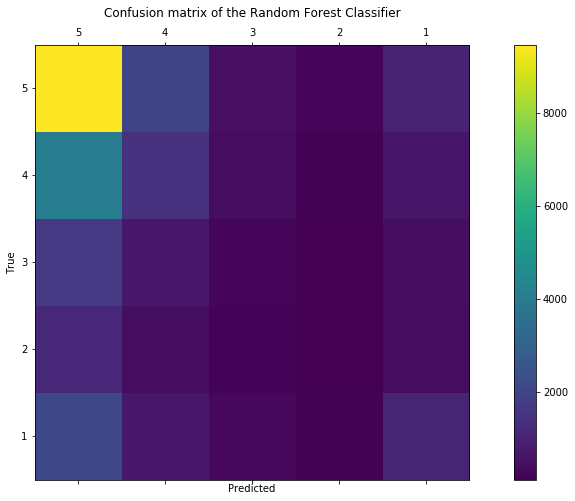

In [135]:
from sklearn.metrics import confusion_matrix, classification_report
# Let us now evaluate and plot Confusion Matrix 

labels = [5,4,3,2,1]
rmf_cm = confusion_matrix(y_test, rmf_preds, labels)
print('Confusion matrix of the Random Forest Classifier \n\n',rmf_cm,'\n')
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
cax = ax.matshow(rmf_cm)
plt.title('Confusion matrix of the Random Forest Classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [75]:
# Let us now evaluate our model using classification report
rmf_cr = classification_report(y_test, rmf_preds)
print('          Classification Report for Random Forest Classifier \n')
print(rmf_cr)

          Classification Report for Random Forest Classifier 

              precision    recall  f1-score   support

           1       0.30      0.25      0.27      4423
           2       0.13      0.04      0.07      2382
           3       0.15      0.08      0.10      3208
           4       0.27      0.22      0.24      6742
           5       0.51      0.72      0.60     13245

    accuracy                           0.41     30000
   macro avg       0.27      0.26      0.26     30000
weighted avg       0.36      0.41      0.37     30000



In [136]:
# Let us now calculate accuracy score
rmf_acc = metrics.accuracy_score(y_test, rmf_preds)
print("Acurracy Score of Random Forest Classifer \n")
print(rmf_acc)

Acurracy Score of Random Forest Classifer 

0.41246666666666665


## **Prediction of Positive Reviews**


In [0]:
from random import randint
def predict_review_ds(n,bow_transformer,rand_clf,review_ds):
    value = randint(0,n)
    print('The row that has been selected is', value)
    review_verdict = review_ds['text'][value]
    review_verdict_transformed = bow_transformer.transform([review_verdict])
    predicted_rating = ramd_clf.predict(review_verdict_transformed)[0]
    check_df = pd.DataFrame(columns=review_ds.columns)
    check_df.loc[0] = review_ds.iloc[value]
    check_df['Predicted'] = predicted_rating
    return check_df

In [78]:
predict_review(100,bow_transformer,rand_clf,review_ds)


The row that has been selected is 24


,business_id,cool,date,funny,review_id,stars,text,useful,user_id,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length,Predicted
0,Sfc8Haz2Yri8Mo1L0E0TsA,0,2012-11-06 03:41:43,0,D_UvaenM25iNd6aehTZ0MA,5,"Great food, great service. Obviously fried chi...",0,8NwU4TRsD3S6gIfBqFzDMQ,40,232,4.825,0,14,0,232,5


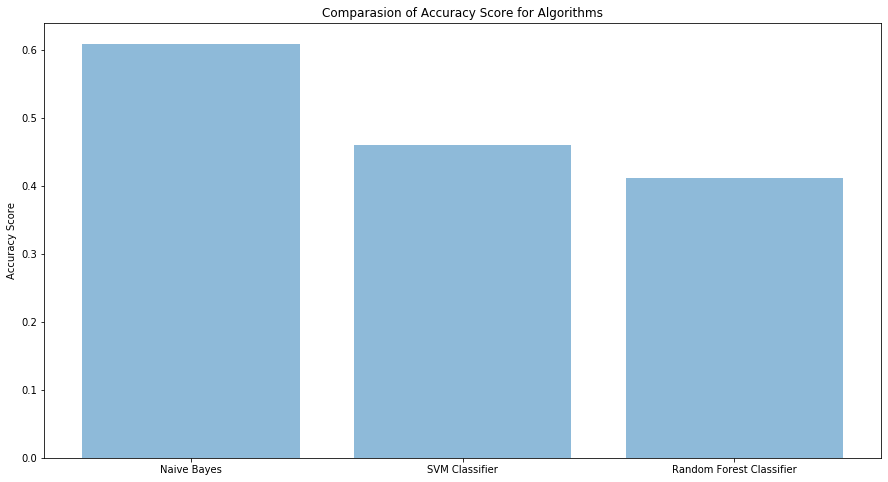

In [79]:
# Plotting all the three Alogritms Accuracy Score

models = ('Naive Bayes', 'SVM Classifier', 'Random Forest Classifier' )
y_pos = np.arange(len(models))
performance = [nb_acc,svm_acc,rmf_acc]
plt.figure(figsize=(15,8))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, models)
plt.ylabel('Accuracy Score')
plt.title('Comparasion of Accuracy Score for Algorithms')

plt.show()



# **4. RECOMENDATION SYSTEM BASED ON USER RATING PREDICTION FOR DIFFERENT MODELS**

Here, we are taking only food related business like restaurants, food delivery etc into consideration for implementing recommendation systems in order to predict the user ratings

In [0]:
# taking only those businesses which contain 'Food' as a category 
# And then merging it with review on business_id and user dataset on user_id
business_ds['categories'] = business_ds['categories'].astype(str)
restaurant_df = business_ds[business_ds['categories'].str.contains('Food')==True]
complete_df = restaurant_df.merge(review_ds,on='business_id').merge(user_ds,on='user_id')

In [81]:
# let us look into the complete_df
complete_df.head()

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,cool_x,date,funny_x,review_id,stars_y,text,useful_x,user_id,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length,name_y,review_count_y,yelping_since,useful_y,funny_y,cool_y,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",0,2017-01-27 21:54:30,2,6W0MQHmasK0IsaoDo4bmkw,3,My girlfriend and I went for dinner at Emerald...,3,2K62MJ4CJ19L8Tp5pRfjfQ,238,1475,5.016529,0,84,1,1475,David,57,2014-11-27 22:36:00,58,22,20,"2017,2018","ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",1,3.30,0,0,0,0,0,1,1,5,5,3,1
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",0,2013-06-24 23:11:30,0,BeeBfUxvzD4qNX4HxrgA5g,3,We've always been there on a Sunday so we were...,0,A0kENtCCoVT3m7T35zb2Vg,84,439,4.238095,0,47,0,439,Anastasia,348,2009-02-15 16:45:34,411,86,122,"2016,2017,2018","BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,5,2,0,0,0,6,4,5,5,10,1
2,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",0,2016-01-04 12:59:22,0,A1D2kUnZ0HTroFreAheNSg,3,"***No automatic doors, not baby friendly!*** I...",0,SuOLY03LW5ZcnynKhbTydA,43,252,4.883721,0,15,0,252,Jocelyn,105,2014-10-02 14:12:40,150,36,85,"2015,2016,2017,2018","bg2-7AvWq-vJs54NN0X-yQ, 697iJkhX1mkVF9RNhn114Q...",6,3.72,3,0,0,0,0,3,4,8,8,10,1
3,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",2,2011-03-21 14:39:55,1,RHhlmL07evgAdPaXQV8Omg,4,One of the gauges of a good Chinese restaurant...,2,6vU0I5XgCv9OQHZ76rV6qw,318,1668,4.177570,0,130,2,1668,Marc,6,2011-03-05 23:31:39,11,4,6,,"yUNU1KTKs4gzxBEuZWQg8Q, zHrHUdxKq7FEURYHusrtIw...",0,3.29,0,0,0,1,0,0,0,1,1,0,0
4,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",0,2015-02-17 00:10:02,0,TD5E5NTFqgi1LPbTLlRCjQ,3,We chose this restaurant for our Chinese New Y...,0,-ga7pQvnJcMB1_pIapHQRQ,79,409,4.189873,0,33,0,409,Tracy,73,2014-02-23 15:07:46,58,18,12,"2016,2017","aE8OTrgaYpPZoRmBghRVJA, 4bxhIKz9ePWqD93UkEjnbg...",7,3.32,1,3,0,2,0,5,3,1,1,3,0


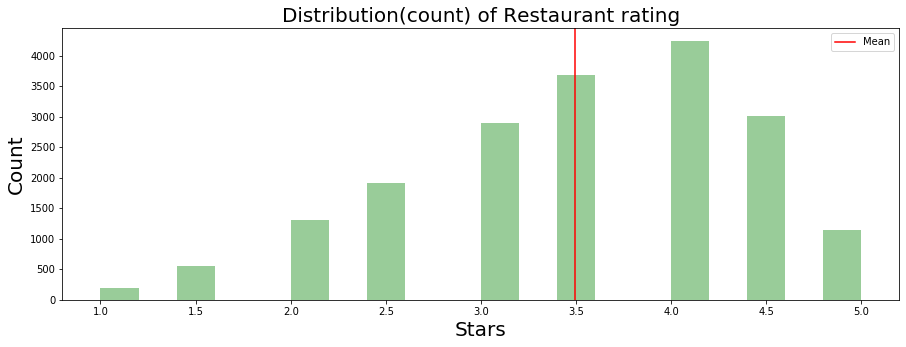

In [82]:
# Distribution count of the restaurent rating !!
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.distplot(restaurant_df.stars,kde=False,color = 'g',ax =ax,bins=20);
ax.axvline(restaurant_df.stars.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Stars',size=20)
ax.set_title('Distribution(count) of Restaurant rating',size=20);

From the above graph we can observe that most businesses have got 4 star rating and an average of over 3.5 rating.



Text(0.5, 1.0, 'Distribution(count) of different Reviews rating')

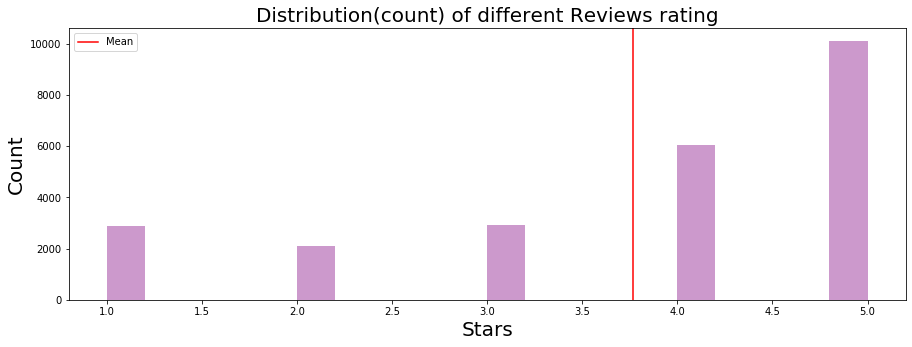

In [83]:
# Distribution count of review ratings
# Review just for business which are restautrants
review_df_filter_df = review_ds.merge(restaurant_df,how='inner',on='business_id')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.distplot(review_df_filter_df.stars_x,kde=False,color = 'purple',ax =ax,bins=20);
ax.axvline(review_df_filter_df.stars_x.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Stars',size=20)
ax.set_title('Distribution(count) of different Reviews rating',size=20)

From above we see that most of the reviews have got 5 star rating and and average of about 3.8 rating.



Text(0.5, 1.0, 'Distribution(count) of User given rating')

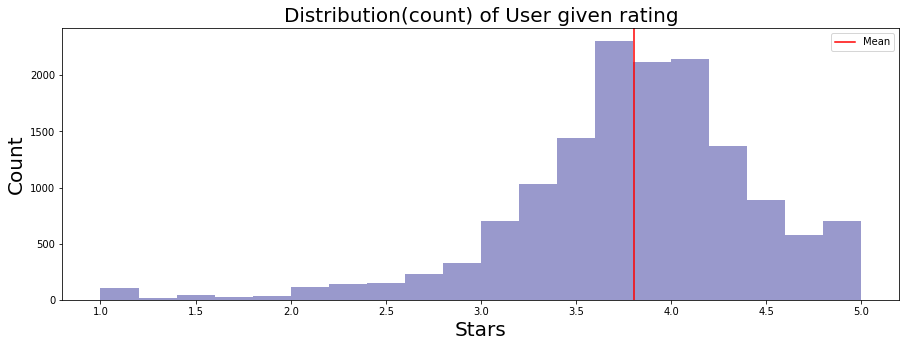

In [84]:
# Distribution count of user ratings just for the business which are restaurent !!
user_df_filter_df = complete_df.groupby(['user_id'],as_index=False).mean()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.distplot(user_df_filter_df.average_stars,kde=False,color = 'navy',ax =ax,bins=20);
ax.axvline(user_df_filter_df.average_stars.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Stars',size=20)
ax.set_title('Distribution(count) of User given rating',size=20)

From above we see that the average user ratings for a restaurent is around 3.7



# **DATA SELECTION FOR USER RATING PREDICTION**


In [0]:
# taking only required parameters for baselienonly model where we need to predict the user rating for business
baseline_df = complete_df[['user_id','business_id','stars_y']]

In [86]:
# let us look at the baseline_df
baseline_df.tail(15)

,user_id,business_id,stars_y
16931,gk2tLQ6zRuSxdRDy5NIBZA,G0EJjh-dqJBmSEhQRog-hQ,5
16932,vFEHN7-NHrvWJ40Lgd7duA,6gjN17SOU28lAb8jGukLRg,5
16933,s1Fxb2D2e9cPmu9SucgFFA,JwYpz-K-kZxeWpM1_OEldQ,5
16934,IAlYZGVT_6B_BK8UrUYOkQ,JwYpz-K-kZxeWpM1_OEldQ,4
16935,LuYIMPQr0IeLVj2AQ36dzw,JwYpz-K-kZxeWpM1_OEldQ,4
16936,LuYIMPQr0IeLVj2AQ36dzw,JwYpz-K-kZxeWpM1_OEldQ,4
16937,-HMryuf0scfllObkYFF0hg,JwYpz-K-kZxeWpM1_OEldQ,3
16938,1ViT_LzrNbbrheWgIvT5Tw,JwYpz-K-kZxeWpM1_OEldQ,4
16939,0rEGb1hmK_Br4UGOfOBHpg,JwYpz-K-kZxeWpM1_OEldQ,4
16940,pF7cTPM1wBAJV4us8AjfrA,JwYpz-K-kZxeWpM1_OEldQ,5


In [0]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy

# creating a reader object to parse the dataframe which has rating_scale of 1-5
reader = Reader(rating_scale=(1, 5))

# Load the dataset and split it into 3 folds for cross-validation
data = Dataset.load_from_df(baseline_df,reader)
trainset, testset = train_test_split(data, test_size=0.25)


# **2.1 BASELINEONLY MODELLING FOR USER RATING PREDICTION**

BaselineOnly is an algorithm predicting the baseline estimate for given user and item Ym = μ + su + sm where the unknown parameters su and sm indicate the deviations, or biases, of user u and item m respectively from some intercept parameter. It is one of the built-in algorithm which focus on user rating prediction for a particular business.

In [88]:

# Baselineonly model
algo = BaselineOnly()
# Performance evaluation on the basis of RMSE and MAE metric where we pass the object of BaselineOnly model
algo.fit(trainset)

predictions_suprs = algo.test(testset)
accuracy.mse(predictions_suprs)

# print_perf(perf_baseline)

Estimating biases using als...
MSE: 1.5335


1.533463913152323

In [89]:
# predict the user ratings for business id : JwYpz-K-kZxeWpM1_OEldQ
pred = algo.predict(str('gk2tLQ6zRuSxdRDy5NIBZA'),str('JwYpz-K-kZxeWpM1_OEldQ'),r_ui=3,verbose=True)

user: gk2tLQ6zRuSxdRDy5NIBZA item: JwYpz-K-kZxeWpM1_OEldQ r_ui = 3.00   est = 3.91   {'was_impossible': False}


In [90]:
# predict the user ratings for business id : 6gjN17SOU28lAb8jGukLRg
pred = algo.predict(str('gk2tLQ6zRuSxdRDy5NIBZA'),str('6gjN17SOU28lAb8jGukLRg'),r_ui=4,verbose=True)

user: gk2tLQ6zRuSxdRDy5NIBZA item: 6gjN17SOU28lAb8jGukLRg r_ui = 4.00   est = 3.74   {'was_impossible': False}


In [91]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **2.2.1 KNNBaseline MODEL FOR USER RATING PREDICTION USING PEARSON_BASELINE SIMILARITY**

This algorithm is directly derived from the basic nearest neighbors approach. A basic collaborative filtering algorithm taking into account a baseline rating

In [92]:
# KNNBaseline model with pearson_baseline similarity metric
sim_options = {'name': 'pearson_baseline',
               'shrinkage': 0  # no shrinkage
               }
algo = KNNBaseline(k=40, verbose= True, sim_options = sim_options) #default values passed to KNNBaseline

# Performance evaluation by calculating RMSE and MAE

perf_knn_baseline = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(perf_knn_baseline)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2489  1.2557  1.2447  1.2235  1.2074  1.2360  0.0179  
MAE (testset)     0.9885  0.9961  0.9923  0.9800  0.9678  0.9849  0.0101  
Fit time          7.84    8.04    6.04    7.03    7.42    7.27    0.71    
Test time         0.04    0.04    0.04    0.04    0.0

In [93]:
# predict the user ratings for business id : Gu-xs3NIQTj3Mj2xYoN2aw
knn_pred = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('Gu-xs3NIQTj3Mj2xYoN2aw'),r_ui=3,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: Gu-xs3NIQTj3Mj2xYoN2aw r_ui = 3.00   est = 3.71   {'was_impossible': False}


In [94]:
# predict the user ratings for business id : 6gjN17SOU28lAb8jGukLRg
knn_pred_2 = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('6gjN17SOU28lAb8jGukLRg'),r_ui=4,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: 6gjN17SOU28lAb8jGukLRg r_ui = 4.00   est = 3.81   {'actual_k': 0, 'was_impossible': False}


# **2.2.2 KNNBaseline MODEL FOR USER RATING PREDICTION USING COSINE SIMILARITY**


In [95]:
# KNNBaseline model with cosine similarity metric
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between users
              }
algo = KNNBaseline(k=40, verbose= True, sim_options = sim_options)

# Performance

perf_knn_baseline = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(perf_knn_baseline)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2595  1.2303  1.2363  1.2354  1.2341  1.2391  0.0104  
MAE (testset)     1.0034  0.9883  0.9850  0.9877  0.9830  0.9895  0.0072  
Fit time          6.87    7.26    8.17    7.91    7.01    7.44    0.51    
Test time         0.04    0.04    0.04    0.04    0.04    0.04    0.00    
{'test_rmse': array([1.25947

In [96]:
# predict the user ratings for business id : Gu-xs3NIQTj3Mj2xYoN2aw
knn_cosine_pred = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('Gu-xs3NIQTj3Mj2xYoN2aw'),r_ui=3,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: Gu-xs3NIQTj3Mj2xYoN2aw r_ui = 3.00   est = 3.70   {'was_impossible': False}


In [97]:
# predict the user ratings for business id : RwRNR4z3kY-4OsFqigY5sw
knn_cosine_pred2 = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('RwRNR4z3kY-4OsFqigY5sw'),r_ui=4,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: RwRNR4z3kY-4OsFqigY5sw r_ui = 4.00   est = 3.70   {'was_impossible': False}


In [98]:

# KNNBaseline model with cosine similarity metric
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between Items
              }
algo = KNNBaseline(k=40, verbose= True, sim_options = sim_options)

# Performance
perf_knn_baseline = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(perf_knn_baseline)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2554  1.2303  1.2430  1.2492  1.2182  1.2392  0.0134  
MAE (testset)     1.0048  0.9775  0.9868  0.9948  0.9690  0.9866  0.0126  
Fit time          0.37    0.30    0.27    0.29    0.25    0.30    0.04    
Test time         0.02    0.03    0.03    0.03    0.02    0.03    0.00    
{'test_rmse': array([1.25535

In [99]:
# predict the user ratings for business id : Gu-xs3NIQTj3Mj2xYoN2aw
knn_cosine_pred3 = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('Gu-xs3NIQTj3Mj2xYoN2aw'),r_ui=3,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: Gu-xs3NIQTj3Mj2xYoN2aw r_ui = 3.00   est = 3.78   {'was_impossible': False}


In [100]:

# predict the user ratings for business id : RwRNR4z3kY-4OsFqigY5sw
knn_cosine_pred2 = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('RwRNR4z3kY-4OsFqigY5sw'),r_ui=4,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: RwRNR4z3kY-4OsFqigY5sw r_ui = 4.00   est = 3.78   {'was_impossible': False}


# **2.3 COLLABORATIVE FILTERING**

In this section, we will use a technique called Collaborative Filtering to make recommendations to Yelp users. Collaborative Filtering is based on the idea that users similar to me can be used to predict how much I will like a particular restaurent those users have experienced but I have not.

We are using the Surprise library that has extremely powerful algorithms like Singular Value Decomposition (SVD) and SVDpp to minimise RMSE (Root Mean Square Error) and give great recommendations

# **2.3.1 SINGULAR-VALUE DECOMPOSITION (SVD)**


The two primary areas of collaborative filtering are the neighborhood methods and latent factor models.

Neighborhood methods are centered on computing the relationships between items or, alternatively, between users. The item oriented approach evaluates a user’s preference for an item based on ratings of “neighboring” items by the same user. A product’s neighbors are other products that tend to get similar ratings when rated by the same user.

In [101]:
# Let us check the number of unique users and restaurants
n_users = complete_df['user_id'].nunique()
n_restaurants = complete_df['business_id'].nunique()

print('Number of Unique Users: ', n_users)
print('Number of Restaurant: ',n_restaurants)

Number of Unique Users:  14473
Number of Restaurant:  2567


In [0]:
# Creating the nominal variable for  user_id
unique_user_id = pd.DataFrame(complete_df['user_id'].unique(),columns =['user_id']).reset_index()
unique_user_id['new_user_id'] = unique_user_id['index']
del unique_user_id['index']

# Creating the nominal variable for  restaurant_id
unique_business_id = pd.DataFrame(complete_df['business_id'].unique(),columns =['business_id']).reset_index()
unique_business_id['new_business_id'] = unique_business_id['index']
del unique_business_id['index']

In [0]:
# Let us now join the nominal user_id and restaurant_id main dataframe with all the data
new_complete_df = complete_df.merge(unique_user_id,on='user_id',how ='left')
new_complete_df = new_complete_df.merge(unique_business_id,on='business_id',how ='left')

In [104]:
# Let us peek into the new_complete_df
new_complete_df.columns


Index(['business_id', 'name_x', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count_x', 'is_open',
       'attributes', 'categories', 'hours', 'cool_x', 'date', 'funny_x',
       'review_id', 'stars_y', 'text', 'useful_x', 'user_id', 'word_count',
       'char_count', 'avg_word', 'hashtags', 'stopwords', 'numerics',
       'text length', 'name_y', 'review_count_y', 'yelping_since', 'useful_y',
       'funny_y', 'cool_y', 'elite', 'friends', 'fans', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos', 'new_user_id',
       'new_business_id'],
      dtype='object')

In [0]:
df = new_complete_df[['new_user_id','new_business_id','stars_y']]

In [106]:
df.head(10)


,new_user_id,new_business_id,stars_y
0,0,0,3
1,1,0,3
2,2,0,3
3,3,0,4
4,4,0,3
5,5,0,1
6,6,0,3
7,7,0,4
8,8,0,3
9,9,0,4


In [0]:
# creating a reader object to parse the dataframe which has rating_scale of 1-5
reader = Reader(rating_scale=(1, 5))
# Load the dataset and split it into 5 folds for cross-validation
data = Dataset.load_from_df(df,reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [108]:
# SVD Modelling
algo = SVD()
# Performance evaluation on the basis of RMSE and MAE
perf_knn_baseline = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(perf_knn_baseline)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2395  1.2298  1.2039  1.2467  1.2502  1.2340  0.0166  
MAE (testset)     0.9839  0.9819  0.9586  0.9901  1.0004  0.9830  0.0138  
Fit time          0.78    0.72    0.72    0.71    0.73    0.73    0.02    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    
{'test_rmse': array([1.23954353, 1.22976403, 1.2039014 , 1.24668542, 1.25023608]), 'test_mae': array([0.98389627, 0.98194052, 0.95856087, 0.99009641, 1.00038714]), 'fit_time': (0.7757363319396973, 0.7234151363372803, 0.7230370044708252, 0.7137389183044434, 0.7315587997436523), 'test_time': (0.018604516983032227, 0.01875782012939453, 0.01927328109741211, 0.018525123596191406, 0.01853322982788086)}


In [109]:
# train the dataset and find the predictions
trainset = data.build_full_trainset()
algo.fit(trainset)

In [110]:
# predict the user ratings for business id : 0
svd_pred = algo.predict(str('1'),str('0'),r_ui=3,verbose=True)

user: 1          item: 0          r_ui = 3.00   est = 3.81   {'was_impossible': False}


In [111]:
# predict the user ratings for business id : 1
svd_pred1 = algo.predict(str('0'),str('1'),r_ui=3,verbose=True)

user: 0          item: 1          r_ui = 3.00   est = 3.81   {'was_impossible': False}


For business id 0 and 1, we get an estimated prediction of 3.81.
One startling feature of this recommender system is that it doesn't care what the business is. It works purely on the basis of an assigned business ID and tries to predict ratings based on how the other users have predicted the business


# **2.3.2 SINGULAR-VALUE DECOMPOSITION PLUS PLUS (SVDpp)**
This also works purely on the basis of an assigned business ID and tries to predict ratings based on how the other users have predicted the business. The only difference between SVD and SVDpp is that SVDpp algorithm considers implicit user ratings into account.

In [112]:
# SVDpp Modelling
algo = SVDpp()

# Performance
perf_knn_baseline = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(perf_knn_baseline)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2312  1.2488  1.1920  1.2462  1.2340  1.2304  0.0204  
MAE (testset)     0.9780  0.9943  0.9589  1.0171  0.9793  0.9855  0.0194  
Fit time          1.30    1.27    1.25    1.32    1.31    1.29    0.03    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    
{'test_rmse': array([1.23118559, 1.24878904, 1.19201584, 1.24622929, 1.2340216 ]), 'test_mae': array([0.97800159, 0.99430245, 0.95888601, 1.01712932, 0.97928784]), 'fit_time': (1.29616117477417, 1.265038251876831, 1.2535171508789062, 1.3193020820617676, 1.3105201721191406), 'test_time': (0.0243222713470459, 0.024932861328125, 0.024831295013427734, 0.024875164031982422, 0.024760007858276367)}


In [113]:
# predict the user ratings for business id : 0
svdpp_pred = algo.predict(str('1'),str('0'),r_ui=3,verbose=True)

user: 1          item: 0          r_ui = 3.00   est = 3.82   {'was_impossible': False}


In [114]:
# predict the user ratings for business id : 1
svdpp_pred1 = algo.predict(str('0'),str('1'),r_ui=3,verbose=True)

user: 0          item: 1          r_ui = 3.00   est = 3.82   {'was_impossible': False}


For business id 0 and 1, we get an estimated prediction of 3.82
As we see the difference in the predicted rating for both SVD and SVDpp is not much

# **2.4 REVIEWS BASED RESTAURENT RECOMMENDER (CONTENT BASED RECOMMENDATION)**

In [115]:
complete_df.head().T


,0,1,2,3,4
business_id,QXAEGFB4oINsVuTFxEYKFQ,QXAEGFB4oINsVuTFxEYKFQ,QXAEGFB4oINsVuTFxEYKFQ,QXAEGFB4oINsVuTFxEYKFQ,QXAEGFB4oINsVuTFxEYKFQ
name_x,Emerald Chinese Restaurant,Emerald Chinese Restaurant,Emerald Chinese Restaurant,Emerald Chinese Restaurant,Emerald Chinese Restaurant
address,30 Eglinton Avenue W,30 Eglinton Avenue W,30 Eglinton Avenue W,30 Eglinton Avenue W,30 Eglinton Avenue W
city,Mississauga,Mississauga,Mississauga,Mississauga,Mississauga
state,ON,ON,ON,ON,ON
postal_code,L5R 3E7,L5R 3E7,L5R 3E7,L5R 3E7,L5R 3E7
latitude,43.6055,43.6055,43.6055,43.6055,43.6055
longitude,-79.6523,-79.6523,-79.6523,-79.6523,-79.6523
stars_x,2.5,2.5,2.5,2.5,2.5
review_count_x,128,128,128,128,128


In [116]:
# taking only required columns
new_df = complete_df[['name_x', 'business_id', 'categories', 'text']]
new_df.head(25)

,name_x,business_id,categories,text
0,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",My girlfriend and I went for dinner at Emerald...
1,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",We've always been there on a Sunday so we were...
2,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...","***No automatic doors, not baby friendly!*** I..."
3,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",One of the gauges of a good Chinese restaurant...
4,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",We chose this restaurant for our Chinese New Y...
5,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",I went at 230 on a Monday. It was dimsum \n\nI...
6,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",My family and I were at Emerald yesterday duri...
7,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...","Because we are in Mississauga, I think this pl..."
8,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...","Whenever I go here on the weekend, this place ..."
9,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Came on a weekday morning with bf to avoid the...


In [117]:
new_df['name_x'].unique()

array(['Emerald Chinese Restaurant', 'Rowe Farms', 'Taco Bell', ...,
       'Wine Warehouse', 'Kneaders Bakery and Cafe Chandler',
       'Les Thés David'], dtype=object)

In [0]:
# Computing the vectorisation of review text by fitting and transforming it
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(new_df['text'])

In [119]:
# Let us look at the shape of the matrix
tfidf_matrix.shape

(16946, 539667)

In [0]:
# Let us now compute the cosine similarity for the computed matrix consisting of businesses
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [121]:
# Let us look for the similarity score for first business
cosine_sim[0]

array([1.        , 0.00708426, 0.02453538, ..., 0.00165362, 0.0079861 ,
       0.00339356])

We now have a pairwise cosine similarity matrix for all the businesses in our dataset. The next step is to write a function that returns the 10 most similar businesses based on the cosine similarity score.

In [0]:
# function that returns top 10 most similar businesses based on cosine similarity scores
new_df = new_df.reset_index()
name_x = new_df['name_x']
indices = pd.Series(new_df.index, index=new_df['name_x'])

In [123]:
# val = lambda x: x[1]
# print(val('Taco Bell'))

sorted("This is a test string string from Andrew".split(), key=str.lower)

['a', 'Andrew', 'from', 'is', 'string', 'string', 'test', 'This']

In [0]:
def get_recommendations(name_x,cosine_sim=cosine_sim):
    idx = indices[name_x]
    # print(idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    # print(sim_scores)
    # sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # print(sim_scores)
    sim_scores = sim_scores[:-1]
    # print(sim_scores)
    restaurent_indices = [i[0] for i in sim_scores]
    return new_df['name_x'].iloc[restaurent_indices]

In [125]:
print("------ Recommend Other Restaurant ------")
get_recommendations('Wine Warehouse').head(10)

------ Recommend Other Restaurant ------


0    Emerald Chinese Restaurant
Name: name_x, dtype: object

# **3. CONCLUSION**
In the above notebook, we have researched about the user rating prediction using Natural Language Processing on the review text by training our model using Naive Bias Algorithm, SVM Classifier and Random Forest Classifier. 

We have also implemented recommendation system using user rating prediction on various models and recommendation techniques by computing both pearson_baseline and cosine similarity metrics.

The MIT License
Copyright 2019 Soumya Pandey, Abhi Patodi, Rashika Moza

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.